In [1]:
import torch as th
import torch
import torch.nn as nn
import torchvision.transforms as T
import torchvision
from torch.utils.data import Dataset, ConcatDataset, random_split, DataLoader
import matplotlib.pylab as plt
import numpy as np
import os
import torch.nn.functional as F
from torchsummary import summary
import sklearn.metrics as m
from collections import Counter

 # Диск

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!rsync -a "/content/drive/MyDrive/weather/" "/content/weather/"

rsync error: received SIGINT, SIGTERM, or SIGHUP (code 20) at io.c(519) [generator=3.2.7]
rsync error: received SIGINT, SIGTERM, or SIGHUP (code 20) at rsync.c(716) [sender=3.2.7]


# Загрузка датасета

In [4]:
!unzip weather.zip -d /content/data

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: /content/data/weather/train/frost/3921.jpg  
  inflating: /content/data/weather/train/frost/3922.jpg  
  inflating: /content/data/weather/train/frost/3923.jpg  
  inflating: /content/data/weather/train/frost/3924.jpg  
  inflating: /content/data/weather/train/frost/3925.jpg  
  inflating: /content/data/weather/train/frost/3926.jpg  
  inflating: /content/data/weather/train/frost/3927.jpg  
  inflating: /content/data/weather/train/frost/3928.jpg  
  inflating: /content/data/weather/train/frost/3929.jpg  
  inflating: /content/data/weather/train/frost/3930.jpg  
  inflating: /content/data/weather/train/frost/3931.jpg  
  inflating: /content/data/weather/train/frost/3932.jpg  
  inflating: /content/data/weather/train/frost/3933.jpg  
  inflating: /content/data/weather/train/frost/3934.jpg  
  inflating: /content/data/weather/train/frost/3935.jpg  
  inflating: /content/data/weather/train/frost/3936.jpg  
  in

In [5]:
train_path = "/content/data/weather/train"
test_path  = "/content/data/weather/test"

print(os.listdir(train_path), len(os.listdir(train_path)))

['glaze', 'fogsmog', 'lightning', 'snow', 'hail', 'rain', 'rainbow', 'dew', 'frost', 'rime', 'sandstorm'] 11


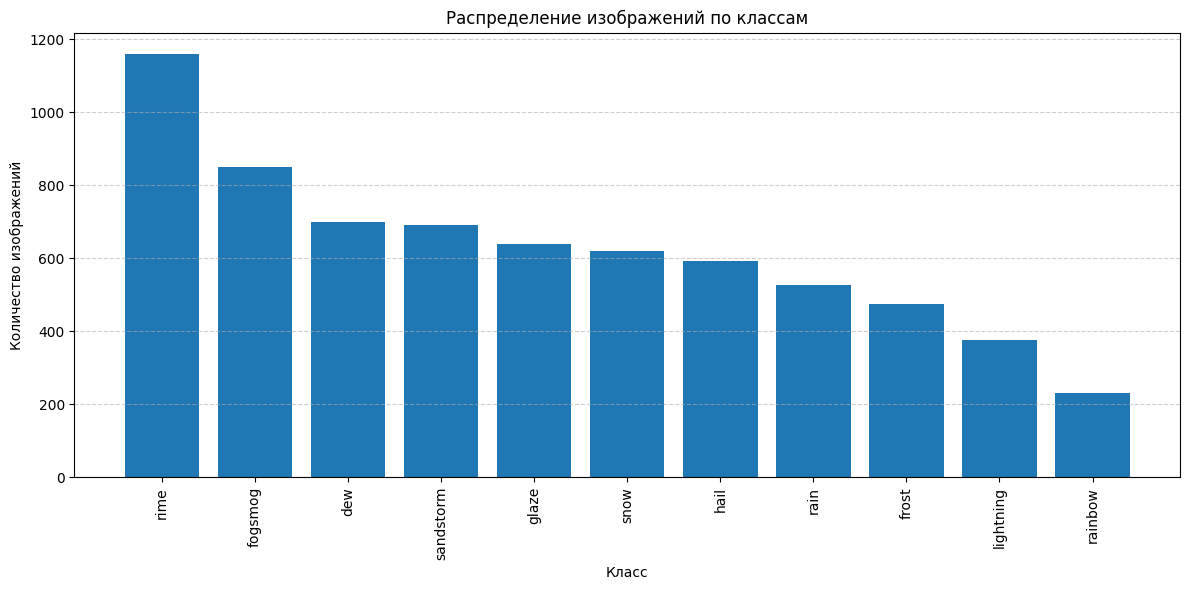

In [6]:
classes = [d for d in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, d))]

# Подсчёт изображений по классам
cnt = Counter()
for c in classes:
    c_path = os.path.join(train_path, c)
    cnt[c] = sum(
        1 for f in os.listdir(c_path)
        if f.lower().endswith((".jpg"))
    )

labels, values = zip(*cnt.most_common())

plt.figure(figsize=(12, 6))
plt.bar(labels, values)
plt.title("Распределение изображений по классам")
plt.xlabel("Класс")
plt.ylabel("Количество изображений")
plt.xticks(rotation=90)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [7]:
t = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
])

train_images = torchvision.datasets.ImageFolder(train_path, transform=t)

test_images = torchvision.datasets.ImageFolder(test_path, transform=t)

class_names = train_images.classes

 # Без аугментации

In [ ]:
val_ratio = 0.2
val_size = int(len(train_images) * val_ratio)
train_size = len(train_images) - val_size

train_ds, val_ds = random_split(
    train_images,
    [train_size, val_size],
    generator=th.Generator().manual_seed(23)
)

train = DataLoader(train_ds, batch_size=64, shuffle=True)
val   = DataLoader(val_ds,   batch_size=64, shuffle=False)

# test  = DataLoader(test_images, batch_size=10, shuffle=False, num_workers=2)

In [ ]:
print("Train samples:", len(train_ds))
print("Val samples:", len(val_ds))

Train samples: 5490
Val samples: 1372


# Аугментация

In [8]:
# считаем количество по классам на исходном train
targets = np.array(train_images.targets)
num_classes = len(class_names)
counts = np.bincount(targets, minlength=num_classes)
max_count = counts.max()

minority_ids = set(np.where(counts * 2 < max_count)[0].tolist())  # count < max/2

print("max_count:", int(max_count))
print("Minority classes (count < max/2):")
for cid in sorted(minority_ids):
    print(f"  {cid}: {class_names[cid]} -> {counts[cid]}")

max_count: 1160
Minority classes (count < max/2):
  2: frost -> 475
  5: lightning -> 377
  6: rain -> 526
  7: rainbow -> 232


In [9]:
# аугментация
aug_tfms = T.Compose([
    T.RandomHorizontalFlip(p=1),
    T.RandomRotation(15),
])

In [10]:
raw_train = torchvision.datasets.ImageFolder(train_path, transform=None)

minority_indices = [i for i, y in enumerate(raw_train.targets) if y in minority_ids]
print("Minority samples in full train:", len(minority_indices))

Minority samples in full train: 1610


In [11]:
# датасет аугментированных копий
class AugmentedCopies(Dataset):
    def __init__(self, raw_ds, indices, aug_tfms, base_tfms):
        self.raw_ds = raw_ds
        self.indices = indices
        self.aug_tfms = aug_tfms
        self.base_tfms = base_tfms

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        base_idx = self.indices[idx]
        img_pil, y = self.raw_ds[base_idx]
        img_pil = self.aug_tfms(img_pil)
        x = self.base_tfms(img_pil)
        return x, y

aug_ds = AugmentedCopies(raw_train, minority_indices, aug_tfms, t)

In [12]:
# исходный + аугментированные копии
train_images_aug = ConcatDataset([train_images, aug_ds])

print("Original train size:", len(train_images))
print("Augmented copies   :", len(aug_ds))
print("Total before split :", len(train_images_aug))

Original train size: 6862
Augmented copies   : 1610
Total before split : 8472


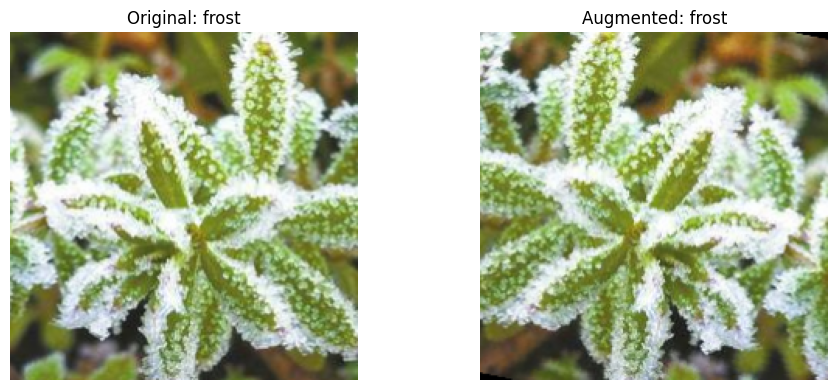

In [13]:
if len(minority_indices) > 0:
    idx0 = minority_indices[0]

    x_orig, y_orig = train_images[idx0]
    img_pil, _ = raw_train[idx0]
    x_aug = t(aug_tfms(img_pil))

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].imshow(x_orig.permute(1,2,0))
    ax[0].set_title(f"Original: {class_names[y_orig]}")
    ax[0].axis("off")

    ax[1].imshow(x_aug.permute(1,2,0))
    ax[1].set_title(f"Augmented: {class_names[y_orig]}")
    ax[1].axis("off")

    plt.tight_layout()
    plt.show()

In [14]:
val_ratio = 0.2
val_size = int(len(train_images_aug) * val_ratio)
train_size = len(train_images_aug) - val_size

train_ds, val_ds = random_split(
    train_images_aug,
    [train_size, val_size],
    generator=th.Generator().manual_seed(23)
)

train = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2, pin_memory=True, persistent_workers=True)
val   = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=2, pin_memory=True, persistent_workers=True)

test  = DataLoader(test_images, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

print("Train split:", len(train_ds))
print("Val split  :", len(val_ds))

Train split: 6778
Val split  : 1694


In [15]:
def targets_concat(train_images_aug, train_images, raw_train, aug_ds):
    # оригинальные метки (ImageFolder)
    targets = list(train_images.targets)

    # метки аугментированных копий
    targets.extend([raw_train.targets[i] for i in aug_ds.indices])

    return np.array(targets)

# targets после аугментации
targets_aug = targets_concat(train_images_aug, train_images, raw_train, aug_ds)

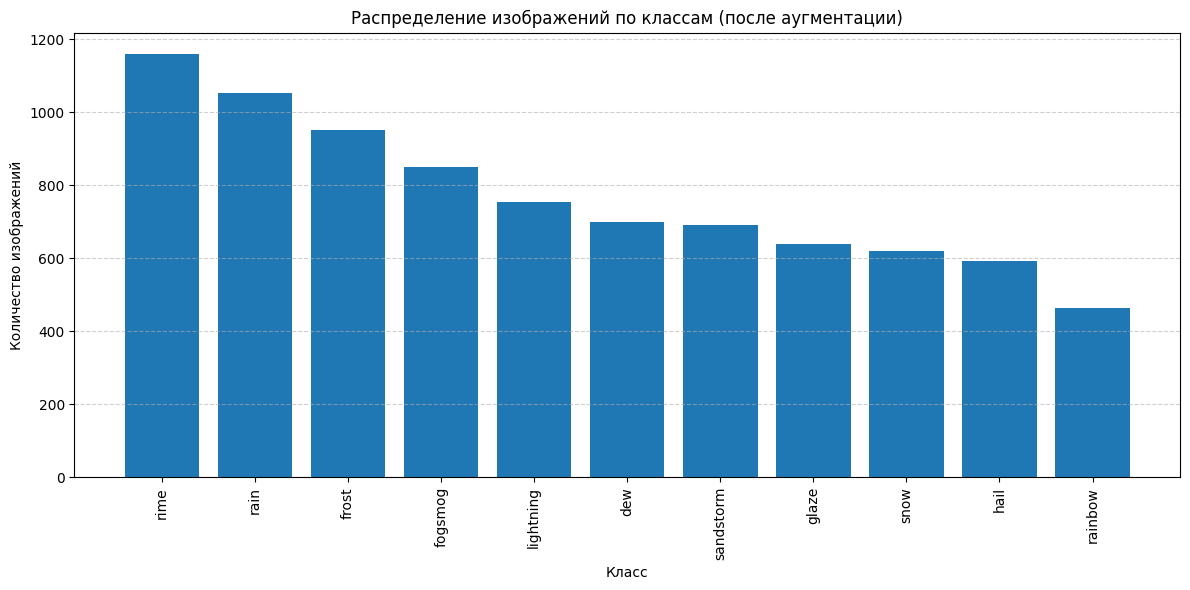

In [16]:
cnt = Counter(targets_aug)
labels = [class_names[i] for i in cnt.keys()]
values = [cnt[i] for i in cnt.keys()]

labels, values = zip(*sorted(zip(labels, values), key=lambda x: x[1], reverse=True))

plt.figure(figsize=(12, 6))
plt.bar(labels, values)
plt.title("Распределение изображений по классам (после аугментации)")
plt.xlabel("Класс")
plt.ylabel("Количество изображений")
plt.xticks(rotation=90)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

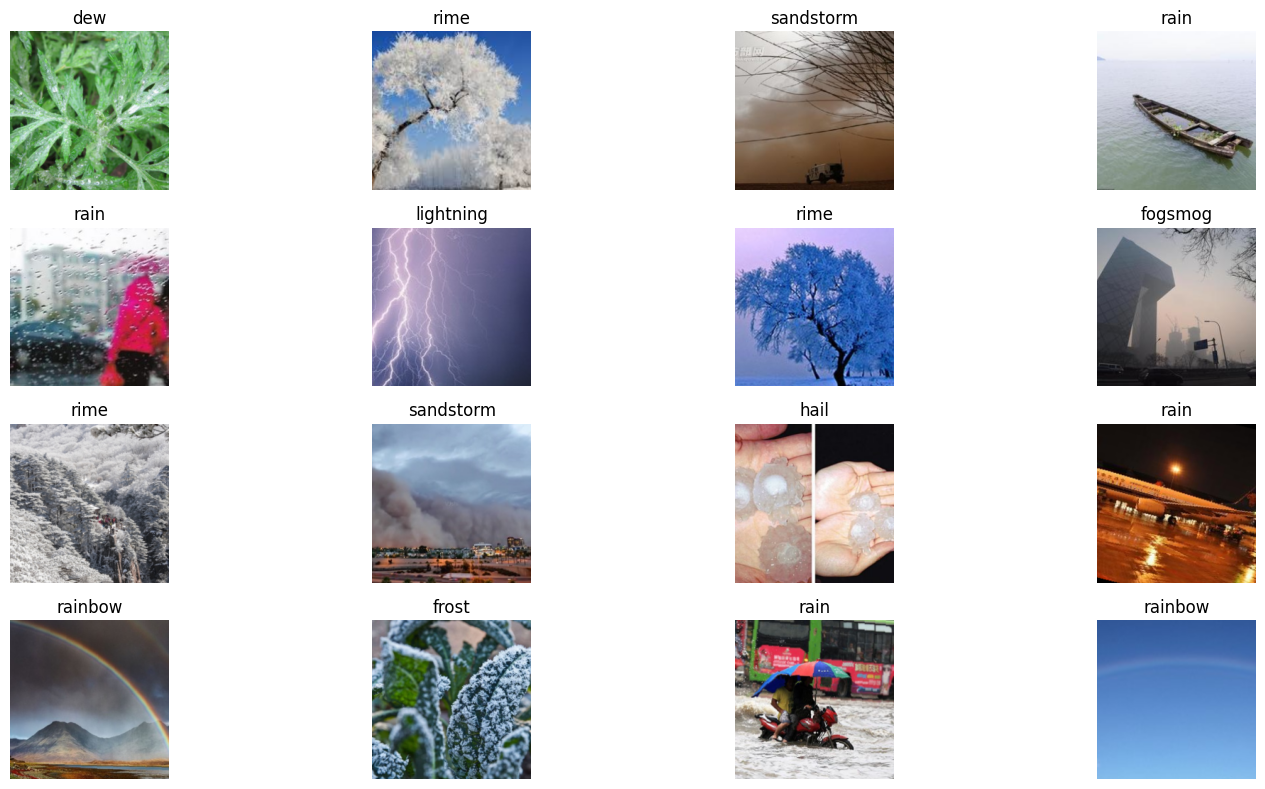

In [17]:
x, y = next(iter(train))

fig, ax = plt.subplots(4, 4, figsize=(16, 8))
i = 0
for row in range(4):
    for col in range(4):
        ax[row, col].imshow(x[i].permute(1, 2, 0))
        ax[row, col].set_title(class_names[int(y[i].item())])
        ax[row, col].axis("off")
        i += 1

plt.tight_layout()
plt.show()

# Обучение

In [18]:
class model(nn.Module):
    def __init__(self, num_classes=11, pool_out=7):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 48, 3, padding=1)

        self.gap = nn.AdaptiveAvgPool2d((pool_out, pool_out))

        self.fc1 = nn.Linear(48 * pool_out * pool_out, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = th.relu(F.max_pool2d(self.conv1(x), 2))
        x = th.relu(F.max_pool2d(self.conv2(x), 2))
        x = th.relu(F.max_pool2d(self.conv3(x), 2))

        x = self.gap(x)
        x = th.flatten(x, 1)
        x = th.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [29]:
net=model()
print(x.shape)
y_hat=net.forward(x)
loss=nn.CrossEntropyLoss()
print(loss(y_hat,y))
print(y_hat.shape)

torch.Size([64, 3, 224, 224])
tensor(2.3997, grad_fn=<NllLossBackward0>)
torch.Size([64, 11])


In [30]:
summary(net, (3, 224, 224),device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
            Conv2d-2         [-1, 32, 112, 112]           4,640
            Conv2d-3           [-1, 48, 56, 56]          13,872
 AdaptiveAvgPool2d-4             [-1, 48, 7, 7]               0
            Linear-5                  [-1, 128]         301,184
            Linear-6                   [-1, 11]           1,419
Total params: 321,563
Trainable params: 321,563
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 10.35
Params size (MB): 1.23
Estimated Total Size (MB): 12.16
----------------------------------------------------------------


In [21]:
def fit(train, val, epochs=10, lr=1e-3):
            dev=th.device("cuda" if th.cuda.is_available() else "cpu")
            net=model().to(dev)
            optim=th.optim.Adam(net.parameters(), lr=lr)
            loss=nn.CrossEntropyLoss()
            train_acu=np.zeros(epochs)
            train_loss=np.zeros(epochs)

            val_acu=np.zeros(epochs)
            val_loss=np.zeros(epochs)

            for i in range(epochs):
                        a=[]
                        b=[]
                        net.train()
                        for x,y in train:
                                x=x.to(dev)
                                y=y.to(dev)
                                y_hat=net.forward(x)
                                l=loss(y_hat,y)
                                optim.zero_grad()
                                l.backward()
                                optim.step()

                                l=l.cpu()
                                y_hat=y_hat.cpu()
                                y=y.cpu()

                                a.append(l.item())
                                k=100*th.mean((th.argmax(y_hat,axis=1)==y).float())
                                b.append(k)

                        train_acu[i]=np.mean(b)
                        train_loss[i]=np.mean(a)
                        net.eval()
                        x,y=next(iter(val))
                        x=x.to(dev)
                        y_hat=net.forward(x)
                        y_hat=y_hat.cpu()
                        y=y.cpu()
                        val_acu[i]=100*th.mean((th.argmax(y_hat,axis=1)==y).float())
                        val_loss[i]=loss(y_hat,y).item()

                        print(f"Epoch {i}: Train Loss: {train_loss[i]}, Train Accuracy: {train_acu[i]}  Val Loss: {val_loss[i]}, Val Accuracy: {val_acu[i]}")
            return train_acu, train_loss,val_acu,val_loss,net

In [31]:
train_acu, train_loss, val_acu, val_loss,net = fit(train,val)

Epoch 0: Train Loss: 1.7921296852939534, Train Accuracy: 38.28277587890625  Val Loss: 1.622337818145752, Val Accuracy: 37.5
Epoch 1: Train Loss: 1.245223268585385, Train Accuracy: 58.68829345703125  Val Loss: 1.3880994319915771, Val Accuracy: 54.6875
Epoch 2: Train Loss: 1.0997914345759265, Train Accuracy: 62.83089828491211  Val Loss: 1.13968026638031, Val Accuracy: 60.9375
Epoch 3: Train Loss: 1.05106638906137, Train Accuracy: 64.25311279296875  Val Loss: 1.2099021673202515, Val Accuracy: 62.5
Epoch 4: Train Loss: 0.9806609575478535, Train Accuracy: 66.96080017089844  Val Loss: 1.1877371072769165, Val Accuracy: 57.8125
Epoch 5: Train Loss: 0.9560003314378127, Train Accuracy: 68.09175872802734  Val Loss: 1.0605621337890625, Val Accuracy: 65.625
Epoch 6: Train Loss: 0.9002269304023599, Train Accuracy: 69.7737045288086  Val Loss: 1.1161274909973145, Val Accuracy: 62.5
Epoch 7: Train Loss: 0.8584542994229298, Train Accuracy: 70.76691436767578  Val Loss: 1.0180835723876953, Val Accuracy: 6

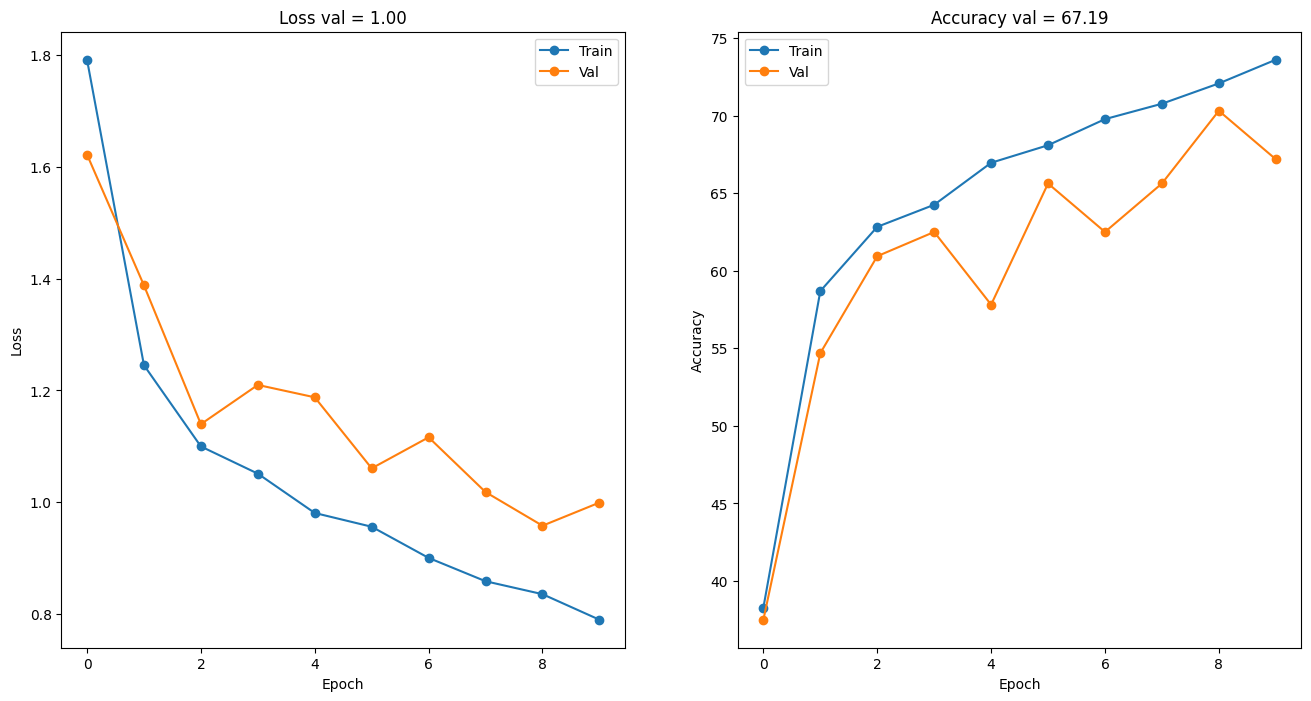

In [32]:
fig,ax=plt.subplots(1,2, figsize=(16,8))
ax[0].plot(train_loss,'o-')
ax[0].plot(val_loss,'o-')
ax[0].set_title(f"Loss val = {val_loss[-1]:.2f}")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel('Loss')
ax[0].legend(["Train","Val"])

ax[1].plot(train_acu,'o-')
ax[1].plot(val_acu,'o-')
ax[1].set_title(f"Accuracy val = {val_acu[-1]:.2f}")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend(["Train","Val"])

In [24]:
save_path = "/content/drive/MyDrive/weather/model.pt"

th.save({
    "model_state_dict": net.state_dict(),
    "class_names": class_names
}, save_path)

print("Модель сохранена в Google Drive:", save_path)

Модель сохранена в Google Drive: /content/drive/MyDrive/weather/model.pt


In [25]:
def eval_report(net, loader):
    dev = th.device("cuda" if th.cuda.is_available() else "cpu")
    net = net.to(dev)
    net.eval()

    y_true = []
    y_pred = []

    with th.no_grad():
        for xb, yb in loader:
            xb = xb.to(dev)
            logits = net(xb)
            pred = th.argmax(logits, dim=1).cpu().numpy()

            y_pred.append(pred)
            y_true.append(yb.numpy())

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    print("Accuracy:", m.accuracy_score(y_true, y_pred))
    print(m.classification_report(y_true, y_pred, digits=4))

In [33]:
eval_report(net, test)

Accuracy: 0.5765765765765766
              precision    recall  f1-score   support

           0     0.6923    0.9000    0.7826        10
           1     1.0000    0.7000    0.8235        10
           2     0.1667    0.2000    0.1818        10
           3     0.7500    0.3000    0.4286        10
           4     0.6000    0.3000    0.4000        10
           5     0.6667    0.5455    0.6000        11
           6     0.5000    0.3000    0.3750        10
           7     0.5882    1.0000    0.7407        10
           8     0.4000    0.8000    0.5333        10
           9     0.8889    0.8000    0.8421        10
          10     0.5556    0.5000    0.5263        10

    accuracy                         0.5766       111
   macro avg     0.6189    0.5769    0.5667       111
weighted avg     0.6194    0.5766    0.5670       111



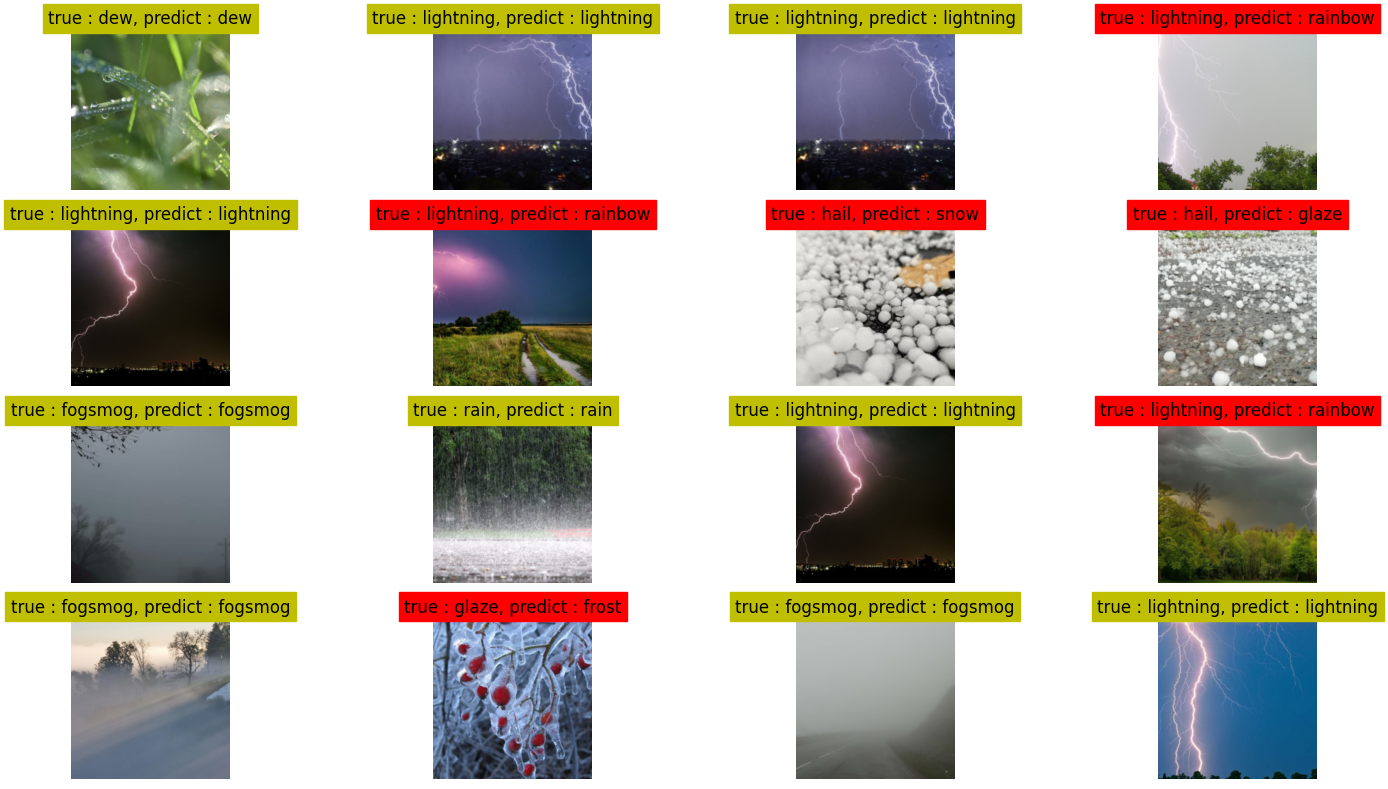

In [34]:
x, y = next(iter(test))

dev = th.device("cuda" if th.cuda.is_available() else "cpu")

# Предсказания для текущего батча
net.eval()
with th.no_grad():
    y_hat = net(x.to(dev))
y_hat1 = th.argmax(y_hat, dim=1).cpu()

x_cpu = x.cpu()

fig, ax = plt.subplots(4, 4, figsize=(16, 8))

for row in range(4):
    for col in range(4):
        co = np.random.randint(0, x_cpu.shape[0])

        ax[row, col].imshow(x_cpu[co].permute(1, 2, 0))
        ax[row, col].axis('off')

        true_id = int(y[co].item())
        pred_id = int(y_hat1[co].item())

        d = f"true : {class_names[true_id]}, predict : {class_names[pred_id]}"

        if true_id == pred_id:
            ax[row, col].set_title(d, color='k', backgroundcolor='y')
        else:
            ax[row, col].set_title(d, color='k', backgroundcolor='r')

plt.tight_layout()
plt.show()

In [27]:
class_to_idx = test_images.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

print("Расшифровка классов:")
for idx in sorted(idx_to_class):
    print(f"{idx}: {idx_to_class[idx]}")

Расшифровка классов:
0: dew
1: fog
2: frost
3: glaze
4: hail
5: lightning
6: rain
7: rainbow
8: rime
9: sandstorm
10: snow
